In [18]:
from micrograd.engine import Value
from graphviz import Digraph

In [2]:
a = Value(-4.0)
b = Value(2.0)

In [3]:
c = 0 + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b-a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f


In [4]:
print(f'{g.data:.4f}')
g.backward()
print(f'{a.grad:.4f}')
print(f'{b.grad:.4f}')

40.6235
-215.3416
-834.4486


In [5]:
print(f'{g._prev}  |  Child 1:{list(g._prev)[0]._prev}    Child 2:{list(g._prev)[1]._prev}')

{Value(data=0.12345679012345678, grad=1), Value(data=40.5, grad=1)}  |  Child 1:{Value(data=10.0, grad=0.012345679012345678), Value(data=0.012345679012345678, grad=10.0)}    Child 2:{Value(data=0.5, grad=81.0), Value(data=81.0, grad=0.4984758420972413)}


## basic math 

In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def f(x):
    return 3*x**2 - 4*x + 5

In [8]:
f(5)

60

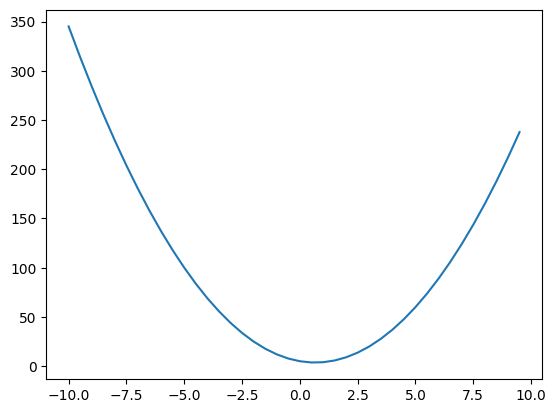

In [9]:
xs = np.arange(-10, 10, 0.5)
y = f(xs)

plt.plot(xs,y)

## Defining class / playing with it

In [43]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [171]:
class NewValue:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # default store formula as nothing
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'NewValue(data={self.data} grad={self.grad})'

    def __add__(self, other):
        other = other if isinstance(other, NewValue) else NewValue(other)
        out = NewValue(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, NewValue) else NewValue(other)
        out = NewValue(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        other = other if isinstance(other, NewValue) else NewValue(other)
        out = NewValue(self.data ** other.data, (self, other), '**')
        def _backward():
            self.grad += (other.data * self.data**(other.data-1)) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = NewValue(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1.0

    def __sub__(self, other):
        return self + (-other)

    def __rmul__(self, other): # tries other * self if self * other can't be done
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1


In [167]:
a = NewValue(1.5, label = 'a')
b = NewValue(-3.0, label = 'b')
c = NewValue(4.0, label = 'c')
d = NewValue(5.5, label = 'd')

ab = a + b ; ab.label = 'a + b'
ad = a - d ; ad.label = 'a - d'

abad = ab + ad; abad.label = 'ab - ad'
abadc = abad + c; abadc.label = 'ab + ad + c'
e = NewValue(0.05, label = 'e')
abadce = abadc*e ; abadce.label = 'abadc * e'
o = abadce.tanh(); o.label = 'o'

In [168]:
# o.grad = 1.0
# o._backward()
# abadce._backward()
# abadc._backward()
# abad._backward()
# ad._backward()
# ab._backward()
o.backward()

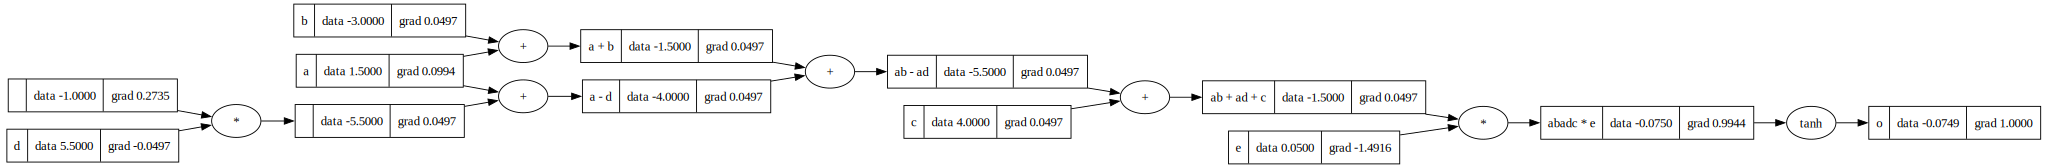

In [169]:

draw_dot(o)

## Pytorch implementation

In [172]:
import torch

In [192]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.88137]).double()
n = x1*w1 + x2*w2 + b 
o = torch.tanh(n)

print(o.data.item())
o.backward()
print(f'x1 grad {x1.grad.item()}')
print(f'x2 grad {x2.grad.item()}')
print(f'w1 grad {w1.grad.item()}')
print(f'w2 grad {w2.grad.item()}')


0.7071050214706146
x1 grad -1.500007465833125
x2 grad 0.5000024886110417
w1 grad 1.0000049772220834
w2 grad 0.0
